# Progressive Entropic Optimal Transport

This tutorial shows how to use the ProgOT algorithm of {cite}`kassraie:24` to estimate Monge maps or recover couplings.

Consider the source and target distributions $\mu, \nu \in \mathcal{P}_2(\Omega)$ where $\Omega \subset \mathbb{R}^d$, which we seek to align with respect to a known translation-invariant cost function $h$. As the input, we are given finite samples  $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$ and $(\mathbf{y}_1, \cdots, \mathbf{y}_n)$ respectively from the source and target distributions, weighted by probability weight vectors $\mathbf{a}\in\mathbb{R}^n_+,\mathbf{b}\in\mathbb{R}^m_+$ summing to $1$. ProgOT is a progressive algorithm that outputs approximate solutions to the OT problem, returning both a coupling matrix $\hat{\mathbf{P}} \in \mathbb{R}^{n\times m}$ that aligns the source and target datasets (primal OT problem), and a map estimator (valid out of sample) $T_{\mathrm{Prog}}: \Omega\rightarrow \Omega$ that pushes forward points from the source to the target.

As the number of samples $n, m$ grows, the map $T_{\mathrm{Prog}}$ provably converges to the Monge map

$$
T_0 = \arg\min_{T: T_{\#}\mu=\nu}\int h(x - T(x))\mathrm{d}\mu(x).
$$

The {class}`~ott.tools.progot.ProgOT` class employs the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm under the hood to solve a sequence of $K$ entropic OT problems. Therefore, in addition to the training data, ProgOT takes in the following hyperparameters:

- $K$ the number of progressive steps,
- $(\alpha_k)_{k\leq K}$ the length of each step, and
- regularization coefficient $(\varepsilon_k)_{k\leq K}$  at each step.

In [1]:
from typing import Any, Optional

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib import colors

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers import linear
from ott.tools import progot

In [2]:
color_dict = {
    "red": "#ff0A47",
    "pink": "#ffc2d1",
    "blue": "#3f88c5",
    "lightblue": "#9fc4e2",
    "green": "#36d99a",
}


def plot_env(
    x=None,
    y=None,
    x_new=None,
    displacement=False,
    displacement_color=color_dict["green"],
    z=None,
    show_map=True,
    marker_size=50,
    ax=None,
):
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 4))

    if x is not None:
        ax.scatter(
            *x.T,
            s=marker_size,
            color=color_dict["pink"],
            marker="o",
            label=r"$\mathbf{x}_{\mathrm{train}}$",
        )
    if y is not None:
        ax.scatter(
            *y.T,
            s=marker_size,
            color=color_dict["lightblue"],
            marker="^",
            label=r"$\mathbf{y}_{\mathrm{train}}$",
        )
    if x_new is not None:
        ax.scatter(
            *x_new.T,
            s=marker_size,
            color=displacement_color if displacement else color_dict["red"],
            marker="*" if displacement else "o",
            label=(
                r"$\mathbf{x}_{\mathrm{interpolate}}$"
                if displacement
                else r"$\mathbf{x}_{\mathrm{test}}$"
            ),
        )
    if z is not None:
        num_showed_maps = int(0.2 * z.shape[0])
        map_points = jax.random.choice(
            jax.random.key(0),
            jnp.arange(z.shape[0]),
            (num_showed_maps,),
            replace=False,
        )
        if show_map:
            ax.quiver(
                *x_new[map_points].T,
                *(z[map_points] - x_new[map_points]).T,
                color="k",
                angles="xy",
                scale_units="xy",
                scale=1,
                alpha=0.6,
                width=0.005,
                zorder=1,
            )
        ax.scatter(
            *z.T,
            s=marker_size,
            color=color_dict["blue"],
            marker="^",
            label=r"$\mathbf{y}_{\mathrm{pred}}$",
        )
    ax.legend(ncol=2)

## Setting up a toy problem

We set up a toy problem to demonstrate the {mod}`ott` implementation of {class}`~ott.tools.progot.ProgOT` and the potential benefits of using ProgOT instead of existing baselines.

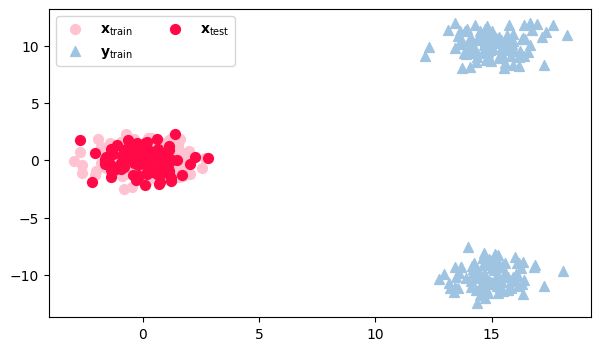

In [3]:
num_train_points = 200
num_test_points = 100
d = 2

keys = jax.random.split(jax.random.key(0), 4)

# setting the cost function
cost_fn = costs.SqEuclidean()

# sampling the training data
x_train = jax.random.normal(keys[0], (num_train_points, d))

y0 = jax.random.normal(keys[1], (num_train_points // 2, d)) + jnp.array(
    [15, 10]
)
y1 = jax.random.normal(keys[2], (num_train_points // 2, d)) + jnp.array(
    [15, -10]
)
y_train = jnp.concatenate([y0, y1])

# Getting a fresh sample from the source distribution
x_test = jax.random.normal(keys[3], (num_test_points, d))

# visualizing the problem
plot_env(x_train, y_train, x_new=x_test)

## Estimating Monge Maps

Our goal is to use the training samples $(\mathbf{x}_{\mathrm{train}}, )$ to estimate the Monge map $T_0$.
 
### Entropic Maps
As a baseline, we consider the entropic map $T_\varepsilon$, which is a consistent estimator for $T_0$ {cite}`pooladian:21`. To this end, we run the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` solver on the problem and obtain a pair of {class}`dual potentials <ott.problems.linear.potentials.DualPotentials>` functions, using which we can calculate the entropic map as follows.

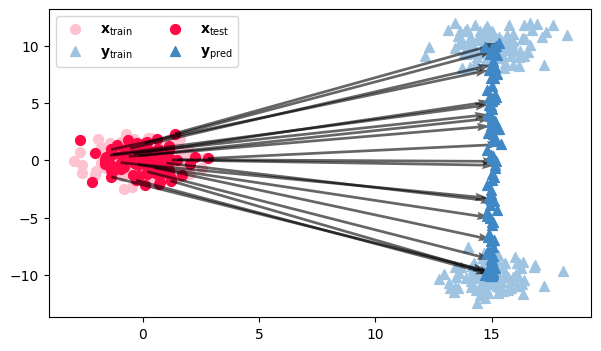

In [4]:
def entropic_map(
    x: jnp.ndarray,
    y: jnp.ndarray,
    cost_fn: costs.TICost,
    epsilon: Optional[float] = None,
) -> potentials.EntropicPotentials:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, epsilon=epsilon)
    output = linear.solve(geom)
    dual_potentials = output.to_dual_potentials()
    return dual_potentials


map_ent = entropic_map(x_train, y_train, cost_fn)
y_test_ent = map_ent.transport(x_test)

plot_env(x_train, y_train, x_new=x_test, z=y_test_ent, show_map=True)

### ProgOT Map

To obtain the {class}`~ott.tools.progot.ProgOT` map estimator $T_{\mathrm{Prog}}$, we instantiate the ProgOT algorithm with $K=4$ steps. While other hyperparameters may be set manually, {mod}`ott` offers schedulers for automatically setting them.

For setting steps lengths $\alpha_k$, we can choose from `lin`, `quad`, and `exp` schemes using {func}`~ott.tools.progot.get_alpha_schedule`, where each scheme describes a pace for progression from source to target (c.f. Section 4 {cite}`kassraie:24`). 

In [5]:
def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out


K = 4
alphas = progot.get_alpha_schedule("exp", num_steps=K)
out = run_progot(x_train, y_train, cost_fn, alphas=alphas, epsilons=None)
xs, ys = out.transport(x_test, return_intermediate=True)

ProgOT can also return a sequence of displacements, as it gradually _moves_ the source towards the target. 
This movement is stored in the list of `xs`. We can visualize the {class}`~ott.tools.progot.ProgOTOutput` and the intermediate interpolations as follows:

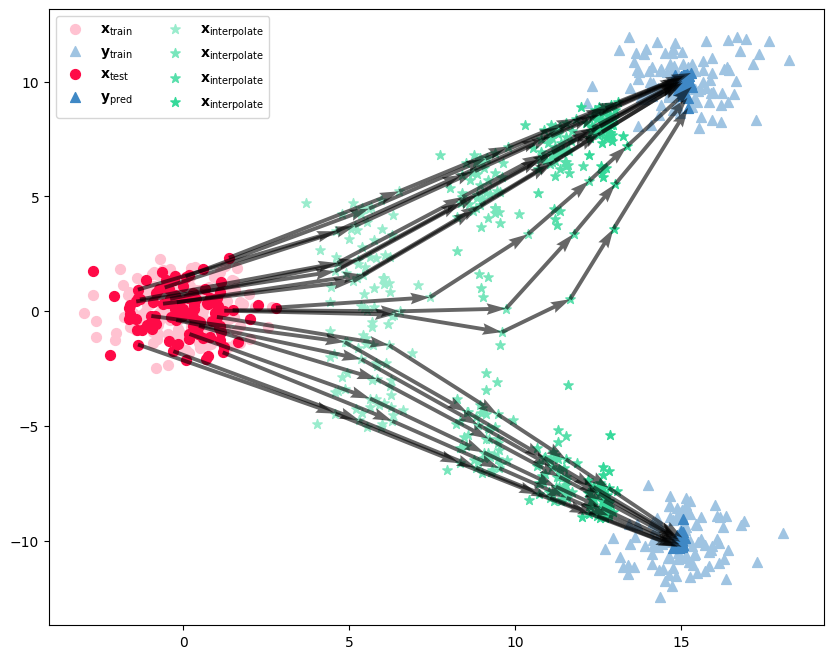

In [6]:
# visualize the output
f, ax = plt.subplots(figsize=(10, 8))
plot_env(x_train, y_train, x_new=x_test, z=ys[-1], show_map=False, ax=ax)

# visualize the intermediate steps
displacement_colors = ["#9aeccd", "#35d99a", "#35d99a"]
cmap = colors.LinearSegmentedColormap.from_list(
    "progot_cmap", ["#9aeccd", "#35d99a"], N=K
)

points = jax.random.choice(
    jax.random.key(0),
    jnp.arange(num_test_points),
    (int(0.2 * num_test_points),),
    replace=False,
)
start_point = x_test[points]
for iteration in range(K):
    plot_env(
        x_new=xs[iteration],
        displacement=True,
        ax=ax,
        displacement_color=cmap(iteration),
        show_map=False,
    )
    ax.quiver(
        *start_point.T,
        *(xs[iteration][points] - start_point).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        alpha=0.6,
        width=0.005,
        zorder=1,
    )
    start_point = xs[iteration][points]
    if iteration == K - 1:
        ax.quiver(
            *start_point.T,
            *(ys[-1][points] - start_point).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            alpha=0.6,
            width=0.005,
            zorder=1,
        )

#### Tuning ProgOT

We ran the above examples with the default values of $\varepsilon_k$ from the {mod}`ott` library. We can improve the performance by using the ProgOT $\varepsilon$-scheduler (c.f. Algorithm 4 {cite}`kassraie:24`) implemented in {func}`~ott.tools.progot.get_epsilon_schedule`.

In [7]:
train_eval_split = int(0.8 * num_train_points)
end_epsilon_scales = jnp.logspace(-10, -9, 4, base=2)
geom = pointcloud.PointCloud(
    x_train, y_train[:train_eval_split], cost_fn=cost_fn
)

tuned_epsilons = progot.get_epsilon_schedule(
    geom,
    alphas=alphas,
    epsilon_scales=end_epsilon_scales,
    start_epsilon_scale=0.5,
    y_eval=y_train[train_eval_split:],
)

out_tuned = run_progot(
    x_train, y_train, cost_fn, alphas=alphas, epsilons=tuned_epsilons
)
xs, ys = out_tuned.transport(x_test, return_intermediate=True)

Visualize the output.

Default values for epsilons [16.520971  10.164162   8.4513855  8.386827 ]
Automatically tuned values for epsilons: [8.25706   5.22642   3.3106909 2.0997183]


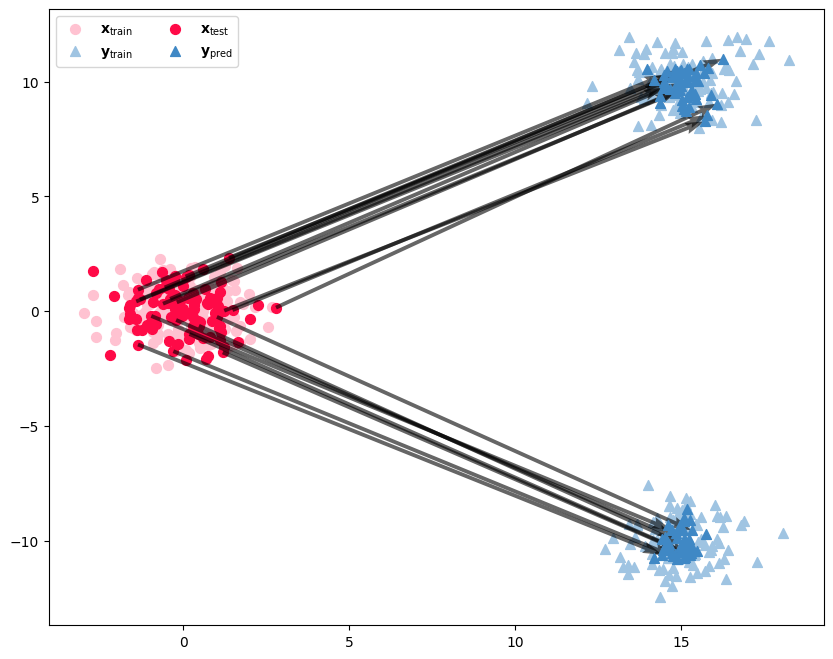

In [8]:
f, ax = plt.subplots(figsize=(10, 8))
plot_env(x_train, y_train, x_new=x_test, z=ys[-1], show_map=True, ax=ax)
print(r"Default values for epsilons", out.epsilons)
print(r"Automatically tuned values for epsilons:", out_tuned.epsilons)

## Recovering Couplings

{class}`~ott.tools.progot.ProgOT` may also be used to calculate a coupling matrix between the source and target point clouds.

In [9]:
# get the coupling matrix of ProgOT
progot_coupling = out_tuned.get_output(-1).matrix

# get the coupling matrix using vanilla Sinkhorn
geom = pointcloud.PointCloud(x_train, y_train, cost_fn=cost_fn)
sinkhorn_coupling = linear.solve(geom).matrix

We visualize the matrices only for the first $\tilde n=20$ and $\tilde m  = 30$ points in the source and target clouds for better visibility.

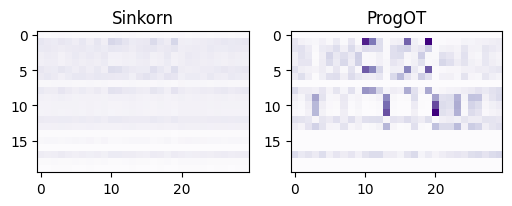

In [10]:
matrix1 = sinkhorn_coupling[:20, :30]
matrix2 = progot_coupling[:20, :30]

vmin = min(matrix1.min(), matrix2.min())
vmax = max(matrix1.max(), matrix2.max())

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
im1 = axs[0].imshow(matrix1, cmap="Purples", vmin=vmin, vmax=vmax)
im2 = axs[1].imshow(matrix2, cmap="Purples", vmin=vmin, vmax=vmax)
_ = axs[0].set_title("Sinkorn")
_ = axs[1].set_title("ProgOT")